# Question 2
## Step 0: Importing libraries
Import libraries for the task

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1 – Load and Inspect the Data

Load the dataset into a pandas daraframa

In [31]:
# Path to csv file
dataFile = "../datasets/Dataset_for_Q2.csv"

# load csv file
df = pd.read_csv(dataFile)

# Basic structure fo the dataset

print("\n################## Shape of dataset is:##################  \n", df.shape)
print("\n################## Columns of dataset are:##################  \n", df.columns.tolist())
print("\n################## Top 5 rows of dataset are:##################  \n", df.head(5))
print("\n################## Last 5 rows of dataset are:##################  \n", df.tail(5))

# Check for missing values
print("\n Number of missing values: \n", df.isna().sum())


# Summary statistics
print("\n##################Statistical Summary of the dataset: ##################\n", df.describe(include="all"))
print("\n################## Dataframe Summary: ##################\n")
df.info()


################## Shape of dataset is:##################  
 (1000, 5)

################## Columns of dataset are:##################  
 ['Age', 'Income', 'SpendingScore', 'NumPurchases', 'LoyaltyLevel']

################## Top 5 rows of dataset are:##################  
     Age       Income  SpendingScore  NumPurchases LoyaltyLevel
0  69.0  53154.57691      58.684106          15.0       Silver
1  32.0  40389.61115     118.300716          17.0       Silver
2   NaN  56045.80144     120.000000          15.0       Silver
3  78.0  22736.86719      99.061927          19.0         Gold
4  38.0  23440.89643     120.000000          19.0         Gold

################## Last 5 rows of dataset are:##################  
       Age       Income  SpendingScore  NumPurchases LoyaltyLevel
995  23.0  58113.93797      55.125156          15.0       Silver
996   NaN  47842.03199      35.026396           8.0       Silver
997  40.0  29213.83962      15.995805          16.0       Bronze
998  64.0  21001.0395

## 1. Missing Value Treatment — Best Method: Group-Wise Median Imputation

The most appropriate method for this dataset is group-wise median imputation by LoyaltyLevel. Because the numerical features (Age, Spending Score, Number of Purchases) are skewed and customer behavior varies by loyalty tier, imputing the median within each LoyaltyLevel group preserves natural customer segments while remaining robust to outliers.

#### Why This Method Is Best

- Handles skew well: The median is resistant to extreme values, unlike the mean.
- Respects customer segmentation: Bronze, Silver, Gold, and Platinum customers differ in spending and activity; imputing within each group keeps these differences intact.
- Preserves dataset size: No rows are removed, which is important for clustering.

#### Why Alternatives Are Weaker

- Global mean/median: Ignores loyalty tiers and distorts cluster structure.
- Row deletion: Removes up to 20% of records, causing data loss and bias.
- KNN imputation: More complex and sensitive to scaling/outliers; unnecessary when loyalty groups already provide a clear structure.

In [34]:
# Copy the dataset
df_imputed = df.copy()

numeric_cols = ["Age", "Income", "SpendingScore", "NumPurchases"]
group_col = "LoyaltyLevel"

for col in numeric_cols:
    if df_imputed[col].isna().sum() > 0:
        df_imputed[col] = df_imputed.groupby(group_col)[col].transform(
            lambda x: x.fillna(x.median())
        )
# Double-check missing values after imputation

print(df_imputed.isna().sum())

Age              0
Income           0
SpendingScore    0
NumPurchases     0
LoyaltyLevel     0
dtype: int64


## 2. Outlier Handling — Reason for Choosing IQR-Based Winsorization (Capping)

IQR-based winsorization is the best method for this dataset because it limits the influence of extreme high values in Income and NumPurchases without removing those customers entirely. Since clustering algorithms like k-means are sensitive to large numeric distances, capping outliers ensures they don’t distort cluster centers while still keeping legitimate high-value customers (e.g., heavy spenders) in the analysis.

#### Why This Method Is Best
- Robust to skewed data: The IQR rule handles asymmetry in Income and Purchasing behavior better than z-scores.
- Prevents distortion: Capping reduces the leverage of extreme values that could pull cluster centroids away from the majority of customers.
- Retains important cases: High-spending or high-purchase customers are kept in the dataset rather than being deleted, preserving meaningful customer segments.

#### Why Alternatives Are Inferior
- Removing outliers: Deletes valuable high-spending customers and harms cluster interpretability.
- Z-score filtering: Assumes normality, which does not hold here due to skewed distributions.
- Doing nothing: A few extreme values would dominate distance calculations and produce biased clusters.

In [4]:
# Columns where outliers will be capped
outlier_cols = ["Income", "NumPurchases"]

def winsorize_iqr(series):
    """
    Caps values above the upper IQR fence: Q3 + 1.5 * IQR.
    This preserves extreme high customers but limits their influence.
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr

    return np.where(series > upper_bound, upper_bound, series)

# Apply winsorization
df_winsorized = df_imputed.copy()
for col in outlier_cols:
    df_winsorized[col] = winsorize_iqr(df_winsorized[col])

# 🔹 Round the columns to 2 decimal places before saving
df_winsorized[outlier_cols] = df_winsorized[outlier_cols].round(2)

# Show capped values
print("Max values after IQR capping and rounding:")
print(df_winsorized[outlier_cols].max())

# Save processed dataset
output_path = "../datasets/output/Dataset_for_Q2_after_outlier_capping.csv"
df_winsorized.to_csv(output_path, index=False)

print(f"\nFile saved as: {output_path}")

Max values after IQR capping and rounding:
Income          91524.68
NumPurchases       27.00
dtype: float64

File saved as: ../datasets/output/Dataset_for_Q2_after_outlier_capping.csv


### Outlier Visualizaion of *Income* and *NumPurchase* before and after handling outlier

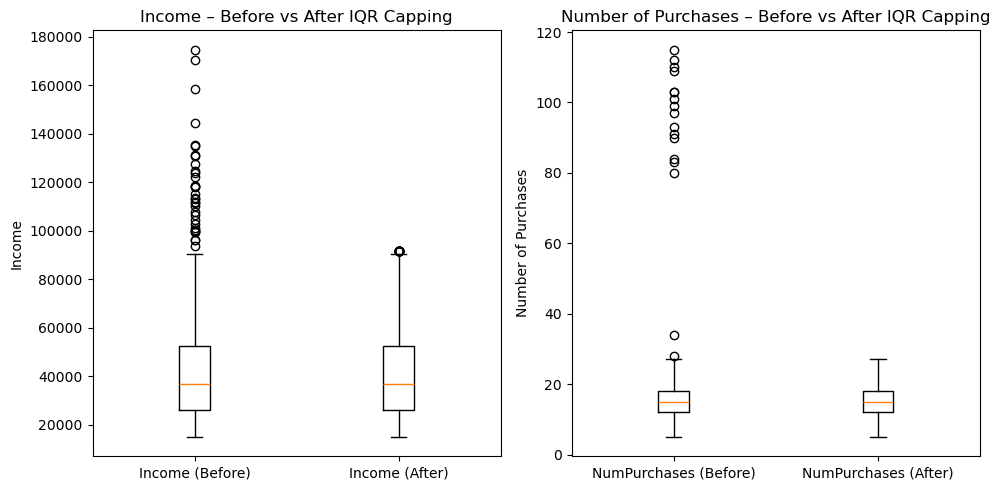

In [5]:
# ---------------------------
# Boxplots: before vs after
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Income
axes[0].boxplot(
    [df["Income"].dropna(), df_winsorized["Income"].dropna()],
    tick_labels=["Income (Before)", "Income (After)"]
)
axes[0].set_title("Income – Before vs After IQR Capping")
axes[0].set_ylabel("Income")

# NumPurchases
axes[1].boxplot(
    [df["NumPurchases"].dropna(), df_winsorized["NumPurchases"].dropna()],
    tick_labels=["NumPurchases (Before)", "NumPurchases (After)"]
)
axes[1].set_title("Number of Purchases – Before vs After IQR Capping")
axes[1].set_ylabel("Number of Purchases")

plt.tight_layout()
plt.show()


## 3. Normalization / Scaling — Best Method: Robust Scaling
Chosen Method: RobustScaler (Median = 0, IQR = 1)

Reason:
The dataset contains skewed distributions (especially in Income and NumPurchases) and still has moderate outliers even after IQR capping. Robust Scaling normalizes all features by subtracting the median and dividing by the IQR, making it far more stable than standardization or min–max scaling when dealing with skew and remaining outliers.

### Why This Method Is Best
- Resistant to outliers: Median and IQR are not distorted by extreme values.
- Handles skewed variables well (Income, Purchases).
- Makes all features comparable for distance-based clustering (e.g., K-means).
- Preserves relative spacing of most observations better than min–max.

### Why Alternatives Are Inferior
- Min–Max Scaling: Highly sensitive to outliers; one very large Income compresses the rest into a tiny range.
- Standardization (Z-score): Uses mean and standard deviation → both influenced heavily by skewed distributions.

### No Scaling:
- Income (in thousands) would dominate distances over Age, SpendingScore, etc.
- Clustering becomes meaningless.

In [6]:
from sklearn.preprocessing import RobustScaler

# Load your cleaned dataset after
# missing value imputation + outlier capping
# --------------------------------------
df = df_winsorized.copy()   # or load from file if needed:
df = pd.read_csv("../datasets/output/Dataset_for_Q2_after_outlier_capping.csv")

# --------------------------------------
# Ordinal encoding for LoyaltyLevel
# (required before scaling)
# --------------------------------------
loyalty_order = {"Bronze": 1, "Silver": 2, "Gold": 3, "Platinum": 4}
df["LoyaltyLevel_Encoded"] = df["LoyaltyLevel"].map(loyalty_order)

# --------------------------------------
# Select features for clustering
# --------------------------------------
features_for_clustering = [
    "Age",
    "Income",
    "SpendingScore",
    "NumPurchases",
    "LoyaltyLevel_Encoded"
]

# --------------------------------------
# Apply RobustScaler
# --------------------------------------
scaler = RobustScaler()
scaled_values = scaler.fit_transform(df[features_for_clustering])

# Convert results to DataFrame
df_scaled = pd.DataFrame(
    scaled_values,
    columns=[f"{col}_scaled" for col in features_for_clustering]
)

# --------------------------------------
# Combine scaled values with original dataset
# --------------------------------------
df_final_scaled = pd.concat([df.reset_index(drop=True), df_scaled], axis=1)

# --------------------------------------
# Save final clustering-ready dataset
# --------------------------------------
output_path = "../datasets/output/Dataset_for_Q2_scaled_for_clustering.csv"
df_final_scaled.to_csv(output_path, index=False)

print("Robust scaling complete.")
print("Saved preprocessed dataset to:", output_path)

df_final_scaled.head()

Robust scaling complete.
Saved preprocessed dataset to: ../datasets/output/Dataset_for_Q2_scaled_for_clustering.csv


,Age,Income,SpendingScore,NumPurchases,LoyaltyLevel,LoyaltyLevel_Encoded,Age_scaled,Income_scaled,SpendingScore_scaled,NumPurchases_scaled,LoyaltyLevel_Encoded_scaled
0,69.0,53154.58,58.684106,15.0,Silver,2,0.84,0.624781,0.235485,0.000000,0.0
1,32.0,40389.61,118.300716,17.0,Silver,2,-0.64,0.135654,2.454465,0.333333,0.0
2,50.0,56045.80,120.000000,15.0,Silver,2,0.08,0.735567,2.517714,0.000000,0.0
3,78.0,22736.87,99.061927,19.0,Gold,3,1.20,-0.540762,1.738381,0.666667,0.5
4,38.0,23440.90,120.000000,19.0,Gold,3,-0.40,-0.513785,2.517714,0.666667,0.5


## 4. Encoding of the Categorical Attribute — Best Method: Ordinal Encoding
Chosen Method: Ordinal encoding of LoyaltyLevel

(Bronze → 1, Silver → 2, Gold → 3, Platinum → 4)

Reason:
LoyaltyLevel represents a natural ordered hierarchy of customer engagement. Converting these levels into ordered numeric values preserves this ranking and ensures clustering algorithms correctly interpret higher loyalty levels as “more engaged.”

#### Why This Method Is Best
- Respects natural order (Bronze < Silver < Gold < Platinum).
- Keeps the relationship meaningful for clustering.
- Produces a single, clean numeric feature instead of expanding dimensionality.
- Works well with distance-based algorithms once scaled.

### Why Alternatives Are Inferior
- One-hot encoding
    - Removes the natural order and creates 4 extra columns
    - Increases dimensionality unnecessarily
- Frequency or count encoding: Encodes based on how common each category is, not its loyalty rank
- Leave-as-text: Many clustering models cannot handle non-numeric values
- Target encoding: Introduces leakage by encoding based on downstream behavior (e.g., spending)

In [7]:
# Start from your winsorized or imputed dataset
df_encoded = df_winsorized.copy()   # or df_imputed, depending on the step

# Define the ordered mapping
loyalty_order = {
    "Bronze": 1,
    "Silver": 2,
    "Gold": 3,
    "Platinum": 4
}

# Apply encoding
df_encoded["LoyaltyLevel_Encoded"] = df_encoded["LoyaltyLevel"].map(loyalty_order)

# Check results
print(df_encoded[["LoyaltyLevel", "LoyaltyLevel_Encoded"]].head())


  LoyaltyLevel  LoyaltyLevel_Encoded
0       Silver                     2
1       Silver                     2
2       Silver                     2
3         Gold                     3
4         Gold                     3
